In [1]:
import os
import time
import glob
import tables as tb
import numpy  as np
import pandas as pd

from invisible_cities.core.system_of_units import year, day, s, mBq, kg, dalton, m, cm
from invisible_cities.database.load_db     import RadioactivityData

os.environ["ZFIT_DISABLE_TF_WARNINGS"] = "1"
import zfit
import hist

%matplotlib notebook
import matplotlib.pyplot as plt

/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## Load pdf data and create pdfs

In [2]:
def create_pdf(array, obs, obs_ext):
    lim = 6000
    if len(array)>lim:
        array = np.random.choice(array, lim, replace=False)

    data = zfit.Data.from_numpy (obs=obs_ext, array=array)
    pdf  = zfit.pdf.KDE1DimExact(obs=obs, data=data, bandwidth="adaptive_zfit")
    return pdf

def create_pdf_from_hist(array, bins, obs):
    obs_ext = zfit.Space("obs_ext", limits=(bins[0], bins[-1]))
    binc = (bins[1:] + bins[:-1])/2.
    histo, _ = np.histogram(array, bins=bins)
    h    = hist.Hist(hist.axis.Variable(edges=bins, name="obs_ext"), data=histo)
    pdf  = zfit.pdf.HistogramPDF(h)
    data = zfit.Data.from_numpy (obs=obs_ext, array=binc, weights=h)
    pdf  = zfit.pdf.KDE1DimExact(obs=obs, data=data, bandwidth="adaptive_zfit")
    return pdf

In [9]:
filename = "./create_pdfs/pdfs_2.4_2.5_MeV.h5"

eff_df = pd.read_hdf(filename, "efficiencies")
with tb.open_file(filename) as hdf:
    
    energy_obs_ext= zfit.Space( "obs", limits=(2.40, 2.50))
    energy_obs    = zfit.Space( "obs", limits=(2.42, 2.48))
    pdf_energy_bb = create_pdf(getattr(hdf.root.energy, "0nubb").read(), energy_obs, energy_obs_ext)
    pdf_energy_Bi = create_pdf(getattr(hdf.root.energy, "214Bi").read(), energy_obs, energy_obs_ext)
    pdf_energy_Tl = create_pdf(getattr(hdf.root.energy, "208Tl").read(), energy_obs, energy_obs_ext)
    pdf_energy_Xe = create_pdf(getattr(hdf.root.energy, "137Xe").read(), energy_obs, energy_obs_ext)

    eblob2_obs    = zfit.Space("eblob2", limits=(0.00, 1.20))
    pdf_eblob2_bb = create_pdf(getattr(hdf.root.eblob2, "0nubb").read(), eblob2_obs, eblob2_obs)
    pdf_eblob2_Bi = create_pdf(getattr(hdf.root.eblob2, "214Bi").read(), eblob2_obs, eblob2_obs)
    pdf_eblob2_Tl = create_pdf(getattr(hdf.root.eblob2, "208Tl").read(), eblob2_obs, eblob2_obs)
    pdf_eblob2_Xe = create_pdf(getattr(hdf.root.eblob2, "137Xe").read(), eblob2_obs, eblob2_obs)
    
pdf_bb = zfit.pdf.ProductPDF([pdf_energy_bb, pdf_eblob2_bb])
pdf_Tl = zfit.pdf.ProductPDF([pdf_energy_Tl, pdf_eblob2_Tl])
pdf_Bi = zfit.pdf.ProductPDF([pdf_energy_Bi, pdf_eblob2_Bi])
pdf_Xe = zfit.pdf.ProductPDF([pdf_energy_Xe, pdf_eblob2_Xe])

In [10]:
muon_flux = 0.78 * 5.26e-3 /(m**2 * s)
R     = 7.64 * m
theta =  np.arctan(R / (86 * cm + 207.6 * cm))
A     = (2.*np.pi-theta) * R * (5.0 * m)
muon_activity = muon_flux * A /mBq

T12_0nubb  = 1.e+25
enrichment = 0.9
xenon_mass = 71.5 * kg
N0 = enrichment*(xenon_mass/(136. * dalton))

# activities
act_df, _ = RadioactivityData("next100")

# new activities
filename = "NEXT100_newcopper.ods"
df = pd.read_excel(filename, sheet_name=" DB  ACTIVITIES")
df = df.drop(["Unnamed: 1", "Co-60", "K-40", "NEXT100 TOTAL ACTIVITIES FOR DB"], axis=1)
df = df.rename({"NEXUS VOLUME": "G4Volume", "Bi-214": "214Bi", "Tl-208": "208Tl"}, axis=1)
df = pd.melt(df, id_vars="G4Volume", value_vars=["208Tl", "214Bi"])
df = df.rename({"variable": "Isotope", "value": "TotalActivity"}, axis=1)
act_df = df

act_df.loc[len(act_df)] = (   "ACTIVE", "137Xe", muon_activity*3.965e-05) # Xe137 per muon
act_df = act_df.set_index(["Isotope", "G4Volume"])

# simulated exposure
eff_df["exposure"] = eff_df.nsim / (act_df.TotalActivity * mBq) /year

# signal eff
signal_eff = eff_df.loc[("0nubb", "ACTIVE")].npdf / eff_df.loc[("0nubb", "ACTIVE")].nsim
eff_df.drop(("0nubb", "ACTIVE"), inplace=True)

rates = eff_df.npdf / eff_df.exposure
rates = rates.groupby(level=0).sum()
rates.loc["0nubb"] = N0 * (np.log(2)/T12_0nubb) * signal_eff

## Generate random experiment

In [11]:
exposure = 3
nevents = rates * exposure

In [12]:
t0 = time.time()

# divide the sample in signal and background, since Eb2 cut has different efficiencies
# independent sample, since pdfs are not correlated

n = np.random.poisson(nevents.loc["0nubb"])
bb_sample = np.concatenate([pdf_energy_bb.sample(n).numpy(), pdf_eblob2_bb.sample(n).numpy()], axis=1)
n = np.random.poisson(nevents.loc["208Tl"])
Tl_sample = np.concatenate([pdf_energy_Tl.sample(n).numpy(), pdf_eblob2_Tl.sample(n).numpy()], axis=1)
n = np.random.poisson(nevents.loc["214Bi"])
Bi_sample = np.concatenate([pdf_energy_Bi.sample(n).numpy(), pdf_eblob2_Bi.sample(n).numpy()], axis=1)
n = np.random.poisson(nevents.loc["137Xe"])
Xe_sample = np.concatenate([pdf_energy_Xe.sample(n).numpy(), pdf_eblob2_Xe.sample(n).numpy()], axis=1)

sample = np.concatenate([bb_sample, Tl_sample, Bi_sample, Xe_sample])

print("Time (s):", time.time()-t0)

Time (s): 8.504990100860596


<IPython.core.display.Javascript object>


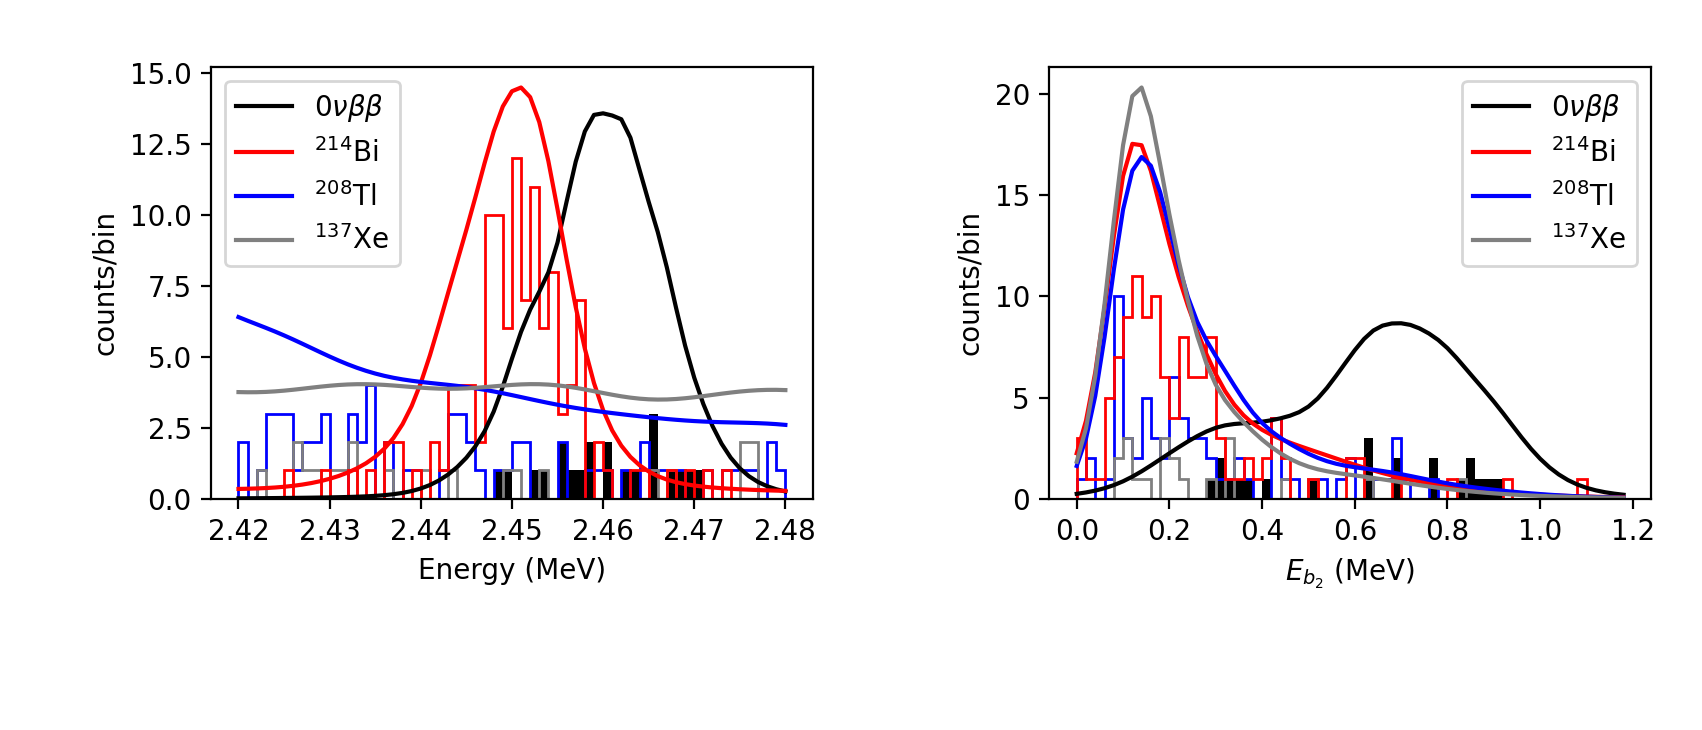

In [13]:
plt.figure(figsize=[5, 2])

plt.subplot(121)
E = np.arange(*energy_obs.limit1d, 0.001)
plt.plot(E, pdf_energy_bb.pdf(E)*len(sample)*np.diff(E)[0], color=   "k", label=r"$0\nu\beta\beta$")
plt.plot(E, pdf_energy_Bi.pdf(E)*len(sample)*np.diff(E)[0], color=   "r", label=r"$^{214}$Bi")
plt.plot(E, pdf_energy_Tl.pdf(E)*len(sample)*np.diff(E)[0], color=   "b", label=r"$^{208}$Tl")
plt.plot(E, pdf_energy_Xe.pdf(E)*len(sample)*np.diff(E)[0], color="gray", label=r"$^{137}$Xe")

# bins = np.arange(*energy_obs.limit1d, 0.001)
# plt.hist(sample[:, 0], bins=E, color="lightgreen", label="sample", histtype="step")
plt.hist(Tl_sample[:, 0], bins=E, color=   "b", histtype="step")
plt.hist(Xe_sample[:, 0], bins=E, color="gray", histtype="step")
plt.hist(Bi_sample[:, 0], bins=E, color=   "r", histtype="step")
plt.hist(bb_sample[:, 0], bins=E, color=   "k")
plt.xlabel("Energy (MeV)")
plt.ylabel("counts/bin")
plt.legend()

plt.subplot(122)
E = np.arange(*eblob2_obs.limit1d, 0.02)
plt.plot(E, pdf_eblob2_bb.pdf(E)*len(sample)*np.diff(E)[0], color=   "k", label=r"$0\nu\beta\beta$")
plt.plot(E, pdf_eblob2_Bi.pdf(E)*len(sample)*np.diff(E)[0], color=   "r", label=r"$^{214}$Bi")
plt.plot(E, pdf_eblob2_Tl.pdf(E)*len(sample)*np.diff(E)[0], color=   "b", label=r"$^{208}$Tl")
plt.plot(E, pdf_eblob2_Xe.pdf(E)*len(sample)*np.diff(E)[0], color="gray", label=r"$^{137}$Xe")

# bins = np.arange(*eblob2_obs.limit1d, 0.01)
# plt.hist(sample[:, 1], bins=E, color="lightgreen", label="sample", density=True)
plt.hist(Tl_sample[:, 1], bins=E, color=   "b", histtype="step")
plt.hist(Xe_sample[:, 1], bins=E, color="gray", histtype="step")
plt.hist(Bi_sample[:, 1], bins=E, color=   "r", histtype="step")
plt.hist(bb_sample[:, 1], bins=E, color=   "k")

plt.xlabel(r"$E_{b_2}$ (MeV)")
plt.ylabel("counts/bin")
plt.legend()

plt.tight_layout()

## Fit

In [14]:
if len(zfit.Parameter._existing_params.data) > 0: 
    zfit.Parameter._existing_params.clear()

N = int(rates.sum()*10)
nbb = zfit.Parameter("nbb", 1, 0, N)
nTl = zfit.Parameter("nTl", 1, 0, N)
nBi = zfit.Parameter("nBi", 1, 0, N)
nXe = zfit.Parameter("nXe", 1, 0, N)

if not pdf_bb.is_extended:
    pdf_bb.set_yield(nbb)
    pdf_Tl.set_yield(nTl)
    pdf_Bi.set_yield(nBi)
    pdf_Xe.set_yield(nXe)

In [15]:
model = zfit.pdf.SumPDF(pdfs=[pdf_bb, pdf_Tl, pdf_Bi, pdf_Xe])

minimizer = zfit.minimize.Minuit(tol=1e-3, gradient=True)

data = zfit.Data.from_numpy(obs=energy_obs * eblob2_obs, array=sample)

In [16]:
t0 = time.time()

nll = zfit.loss.ExtendedUnbinnedNLL(model, data)

result = minimizer.minimize(nll)

param_hesse = result.hesse(method="minuit_hesse", name="hesse")

print("Valid:", result.valid)
print(result.params)

print("Time (min):", (time.time()-t0) / 60)

Valid: True
name      value  (rounded)        hesse    at limit
------  ------------------  -----------  ----------
nbb                20.8086  +/-     6.5       False
nTl                88.5318  +/-      39       False
nBi                118.231  +/-      15       False
nXe                2.42888  +/-      39       False
Time (min): 0.36051084597905475


In [17]:
print("Expected bb:", len(bb_sample))
print("Expected Tl:", len(Tl_sample))
print("Expected Bi:", len(Bi_sample))
print("Expected Xe:", len(Xe_sample))

print("Expected background", len(Tl_sample) + len(Bi_sample) + len(Xe_sample))

Expected bb: 21
Expected Tl: 69
Expected Bi: 119
Expected Xe: 21
Expected background 209


In [18]:
p = result.params
print("Background from fit:", p["nTl"]["value"] + p["nBi"]["value"] + p["nXe"]["value"])

Background from fit: 209.19122757894797
